
# Visualization of CBO
Adapted from [Gaussian Processes regression: basic introductory example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.


In [1]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

## Objective

We will start by generating a synthetic dataset. The true generative process
is defined as $f(x)=(2.4 * e^{-(X-7)^2/4} + 1.5 * e^{-(X-15)^2/2})$.



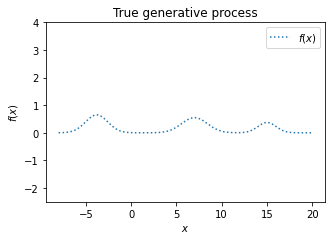

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(start=-8, stop=20, num=1_000).reshape(-1, 1)
# f = lambda X: ((10-X) * np.sin((10-X))/2 - np.abs(X-8)/4) * 2 
# f = lambda X: ((10-X) * np.sin((10-X))/2 + .7 * np.exp(-(X-8)**2) + 3 * np.exp(-(X+1)**2/2)) - 1
f = lambda X: (2.6 * np.exp(-(X+3.8)**2/3) + 2.2 * np.exp(-(X-7)**2/4) + 1.5 * np.exp(-(X-15)**2/2))/4

# g = lambda X: X / 10 if X < 0 else X
# f = lambda X: (np.clip(10-X, a_min=0, a_max=4) * np.sin((10-X)/1.2)/2 )
# y = np.squeeze(f(np.array(list(map(g, X.squeeze()))).reshape(-1, 1)))
y = np.squeeze(f(X))


fig = plt.figure(figsize=[5, 3.3])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-2.5, 4)
_ = plt.title("True generative process")

0.325**2 * RBF(length_scale=2.88)


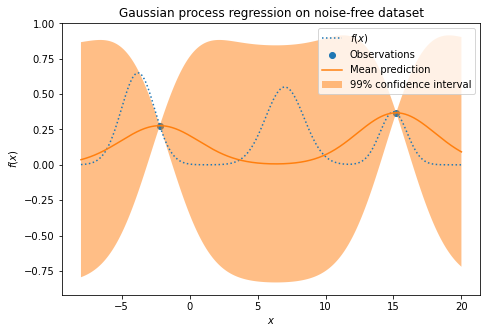

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e0, 3))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)


X_train = np.array([ -2.2, 15.2])[:,np.newaxis]
y_train = f(X_train)

gaussian_process.fit(X_train, y_train)
print(gaussian_process.kernel_)

# plot UCB, LCB and Pred
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
std_prediction = std_prediction.squeeze()
mean_prediction = mean_prediction.squeeze()

lcb, ucb = mean_prediction - 2.576 * std_prediction, mean_prediction + 2.576 * std_prediction,

fig = plt.figure(figsize=[7.5, 5])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb, ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

## Contraints

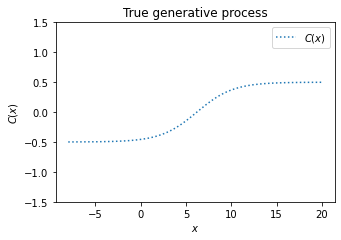

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# X = np.linspace(start=-10, stop=25, num=1_000).reshape(-1, 1)
# f = lambda X: ((10-X) * np.sin((10-X))/2 - np.abs(X-8)/4) * 2 
# f = lambda X: ((10-X) * np.sin((10-X))/2 + .7 * np.exp(-(X-8)**2) + 3 * np.exp(-(X+1)**2/2)) - 1
c = lambda X: (1/(1 + np.exp(-(X-6.2)/2))) - .5

# g = lambda X: X / 10 if X < 0 else X
# f = lambda X: (np.clip(10-X, a_min=0, a_max=4) * np.sin((10-X)/1.2)/2 )
# y = np.squeeze(f(np.array(list(map(g, X.squeeze()))).reshape(-1, 1)))
yc = np.squeeze(c(X))


fig = plt.figure(figsize=[5, 3.3])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$C(x)$")
plt.ylim(-1.5, 1.5)
_ = plt.title("True generative process")

/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.488**2 * RBF(length_scale=5)


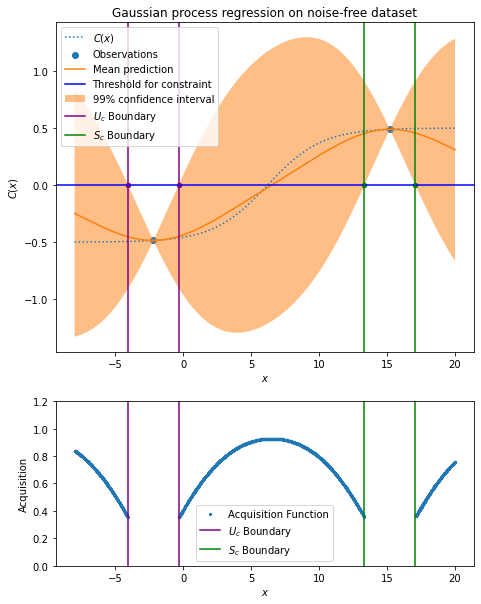

In [5]:
c_train = c(X_train)

kernel_c = 1 * RBF(length_scale=1.0, length_scale_bounds=(5, 1e1))
gaussian_process_c = GaussianProcessRegressor(kernel=kernel_c, n_restarts_optimizer=9)
gaussian_process_c.fit(X_train, c_train)
print(gaussian_process_c.kernel_)

# plot UCB, LCB and Pred
mean_prediction_c, std_prediction_c = gaussian_process_c.predict(X, return_std=True)
std_prediction_c = std_prediction_c.squeeze()
mean_prediction_c = mean_prediction_c.squeeze()

ucb_c, lcb_c = mean_prediction_c + 2.576 * std_prediction_c, mean_prediction_c - 2.576 * std_prediction_c, 

# fig = plt.figure(figsize=[7.5, 12], gridspec_kw={'height_ratios': [2, 1]})
fig, axes = plt.subplots(2, 1, figsize=[7.5, 10], gridspec_kw={'height_ratios': [2, 1]})

# original GP
plt.subplot(2,1,1)
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)

ucb_c_idx = np.argsort(np.abs(ucb_c))[:2]
lcb_c_idx = np.argsort(np.abs(lcb_c))[:2]
# for idx in ucb_c_idx:
#     #label = r'$U_c$ Boundary'
#     plt.axvline(x = X[idx], color = 'purple')
#     plt.scatter(X[idx], 0, s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$U_c$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'purple')

# for idx in lcb_c_idx:
#     #label = r'$S_c$ Boundary'
#     plt.axvline(x = X[idx], color = 'green')
#     plt.scatter(X[idx], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_c$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$C(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

# acquisition function
acq_c = 2 * std_prediction_c
acq_c_filter_ucb = np.logical_or(X.squeeze() < np.min(X[ucb_c_idx]), X.squeeze() >  np.max(X[ucb_c_idx]))
acq_c_filter_lcb = np.logical_or(X.squeeze() <  np.min(X[lcb_c_idx]), X.squeeze() >  np.max(X[lcb_c_idx]))
acq_c_filter = np.logical_and(acq_c_filter_ucb, acq_c_filter_lcb)
plt.subplot(2,1,2,)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=5)
acq_c_argmax = acq_c.argmax()

# plt.scatter()

plt.ylim(0, 1.2)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
# for idx in ucb_c_idx:
#     #label = r'$U_c$ Boundary'
#     plt.axvline(x = X[idx], color = 'purple')
#     plt.scatter(X[idx], 0, s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
# plt.scatter(X[ucb_c_idx[0]], acq_c[ucb_c_idx[0]], s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$U_c$ Boundary')
# plt.scatter(X[ucb_c_idx[1]], acq_c[ucb_c_idx[1]], s=20, color = 'purple')

# for idx in lcb_c_idx:
#     #label = r'$S_c$ Boundary'
#     plt.axvline(x = X[idx], color = 'green')
#     plt.scatter(X[idx], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
# plt.scatter(X[lcb_c_idx[0]], acq_c[lcb_c_idx[0]], s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green', label=r'$S_c$ Boundary')
# plt.scatter(X[lcb_c_idx[1]], acq_c[lcb_c_idx[1]], s=20, color = 'green')
plt.legend()
plt.savefig('EG1D_C.png')



## Updated Obj

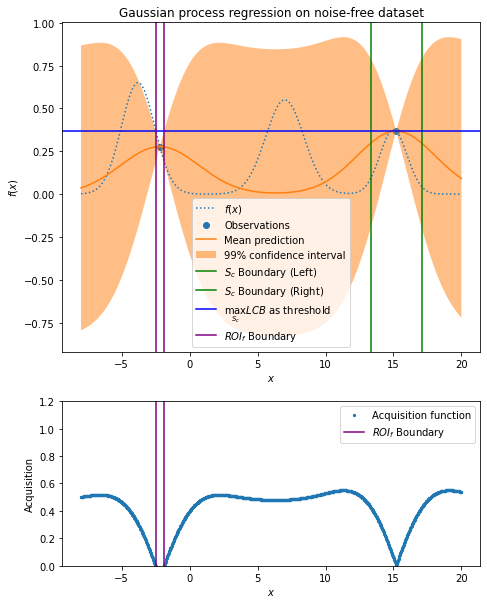

In [6]:
# plot UCB, LCB and Pred
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
std_prediction = std_prediction.squeeze()
mean_prediction = mean_prediction.squeeze()

# fig = plt.figure(figsize=[7.5, 5])
fig, axes = plt.subplots(2, 1, figsize=[7.5, 10], gridspec_kw={'height_ratios': [2, 1]})
plt.subplot(2,1,1)
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)
# label = r'$S_c$ Boundary'
sci_lb, sci_rb = min(X[lcb_c_idx]), max(X[lcb_c_idx])    
plt.axvline(x = sci_lb, color = 'green', label=r'$S_c$ Boundary (Left)')
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_c$ Boundary (Right)')
sci_filter = np.logical_and(X >=sci_lb, X<=sci_rb).squeeze()
lcb_max = lcb[sci_filter].max()
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_c}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
acq_f = ucb - lcb.max()
ucb_f_idx = np.argsort(np.abs(acq_f[X.squeeze()< X_train[-1]]))[:2]
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple', label=r"$ROI_f$ Boundary")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

plt.subplot(2,1,2)
plt.scatter(X, acq_f, label="Acquisition function", s=5)
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple', label=r"$ROI_f$ Boundary")
plt.ylim(0, 1.2)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
plt.legend()
plt.savefig('EG1D_F.png')

## Combine Acquisition

/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


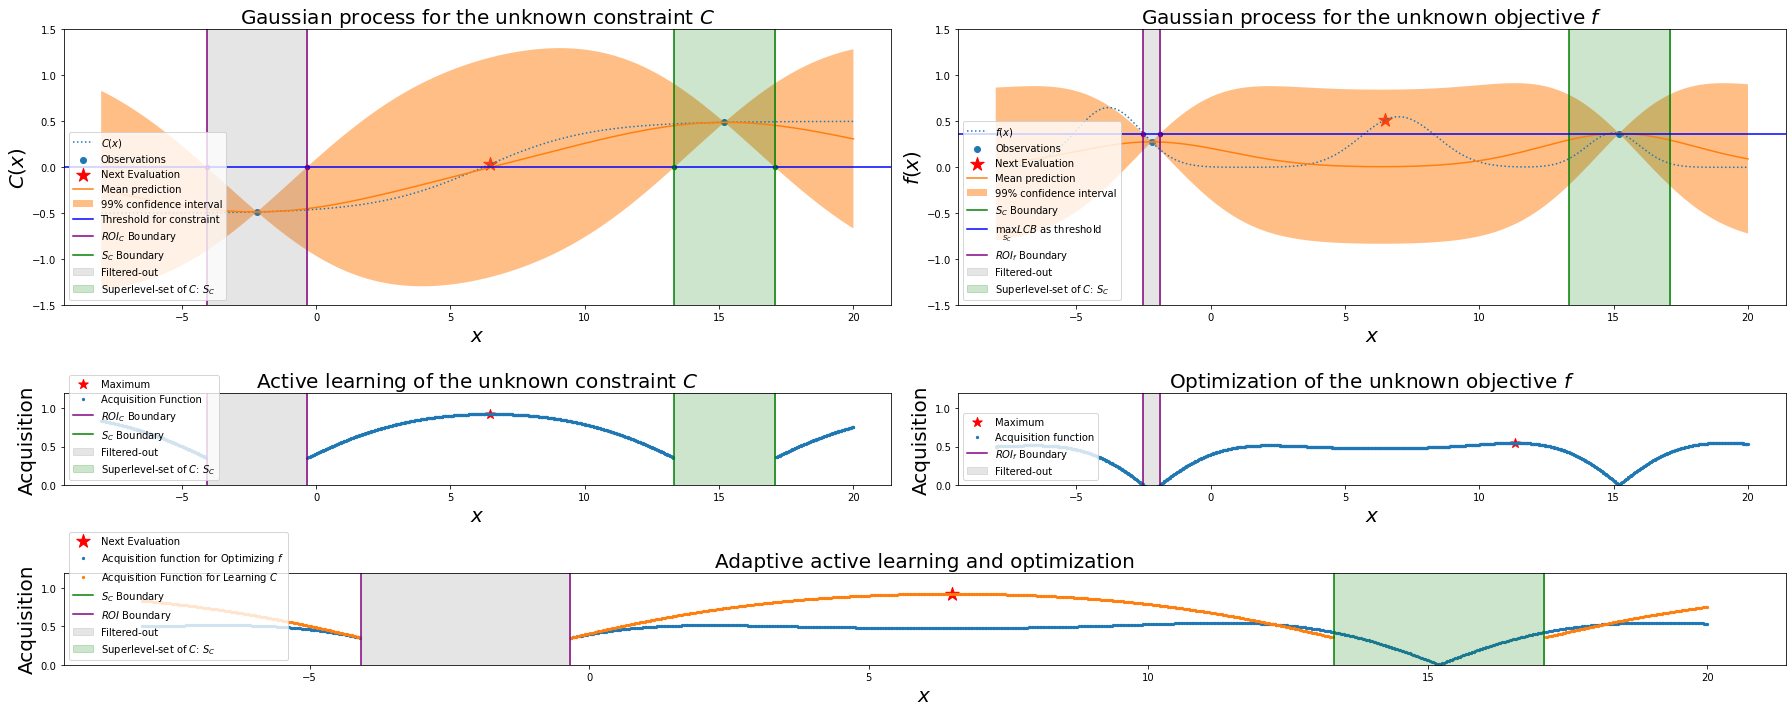

In [7]:
from PIL import Image

# img_f = Image.open(f"EG1D_F.png")
# img_c = Image.open(f"EG1D_C.png")
font_s2 = 20
next_idx = acq_c.argmax()

fig = plt.figure(figsize=[25, 10])
gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1])

plt.subplot(gs[0,0])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.scatter(X[next_idx], yc[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$ROI_C$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'purple')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_C$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower left')
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("$C(x)$", fontsize=font_s2)
_ = plt.title(r"Gaussian process for the unknown constraint $C$", fontsize=font_s2)
plt.ylim(-1.5, 1.5)

# plt.subplot(3,2,2)
plt.subplot(gs[0,1])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.scatter(X[next_idx], y[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)
# label = r'$S_c$ Boundary'
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_C}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
plt.scatter(X[ucb_f_idx[0]], lcb_max, s=20, color = 'purple',)
plt.scatter(X[ucb_f_idx[1]], lcb_max, s=20, color = 'purple',)
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple', label=r"$ROI_f$ Boundary")

plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower left')
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("$f(x)$", fontsize=font_s2)
plt.ylim(-1.5, 1.5)
_ = plt.title(r"Gaussian process for the unknown objective $f$", fontsize=font_s2)


# plt.subplot(3,2,3)
plt.subplot(gs[1,0])
acqc_argmax = acq_c.argmax()
plt.scatter(X[acqc_argmax], acq_c[acqc_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=5)
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$ROI_C$ Boundary')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.axvline(x = X[lcb_c_idx[1]], color = 'green', label=r'$S_C$ Boundary')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')
plt.legend(loc='lower left')
_ = plt.title(r"Active learning of the unknown constraint $C$", fontsize=font_s2)

# plt.subplot(3,2,4)
plt.subplot(gs[1,1])
acqf_argmax = acq_f.argmax()
plt.scatter(X[acqf_argmax], acq_f[acqf_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X, acq_f, label="Acquisition function", s=5)
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple', label=r"$ROI_f$ Boundary")
plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.legend(loc='lower left')
_ = plt.title(r"Optimization of the unknown objective $f$", fontsize=font_s2)

plt.subplot(gs[2,:])
plt.scatter(X[next_idx], acq_c[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.scatter(X[acq_c_filter_ucb], acq_f[acq_c_filter_ucb], label=r"Acquisition function for Optimizing $f$", s=5)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label=r"Acquisition Function for Learning $C$", s=5)
plt.ylim(0, 1.2)
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$ROI$ Boundary')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.legend(loc='lower left')
_ = plt.title(r"Adaptive active learning and optimization", fontsize=font_s2)

plt.tight_layout()
plt.savefig('EG1d.pdf')


/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


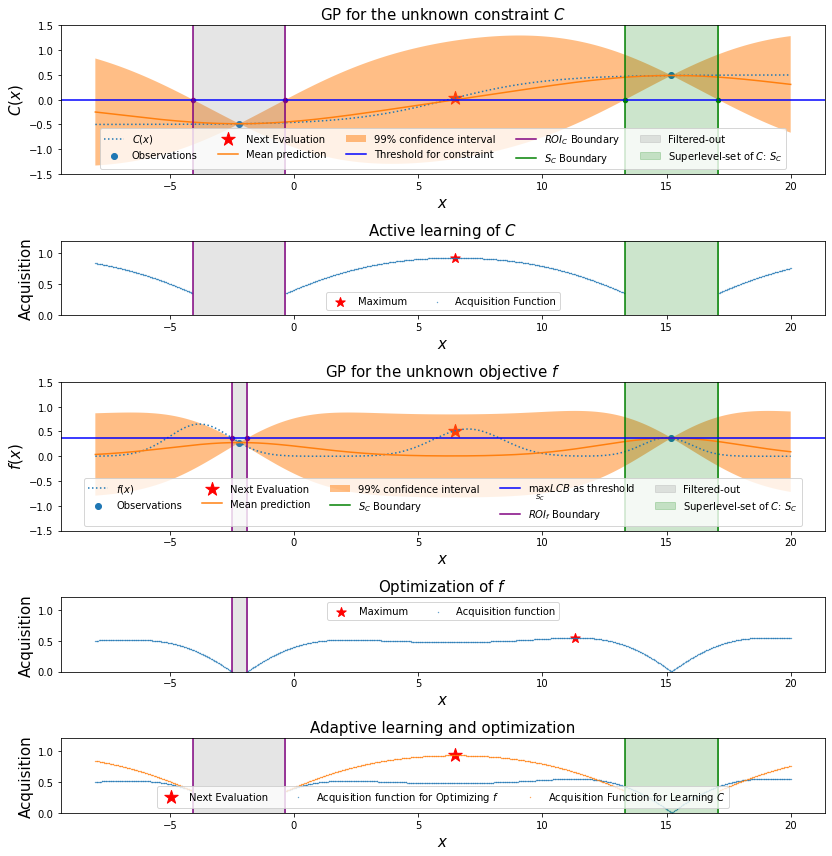

In [17]:
from PIL import Image

# img_f = Image.open(f"EG1D_F.png")
# img_c = Image.open(f"EG1D_C.png")
font_s3 = 15
curve_s3 = .1
next_idx = acq_c.argmax()

fig = plt.figure(figsize=[12, 12])
gs = fig.add_gridspec(5, 1, height_ratios=[2, 1, 2, 1, 1])

plt.subplot(gs[0,0])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.scatter(X[next_idx], yc[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'purple',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple', label=r'$ROI_C$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'purple')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_C$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower center', ncol=5)
plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("$C(x)$", fontsize=font_s3)
_ = plt.title(r"GP for the unknown constraint $C$", fontsize=font_s3)
plt.ylim(-1.5, 1.5)

# plt.subplot(3,2,2)
plt.subplot(gs[2,0])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.scatter(X[next_idx], y[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)
# label = r'$S_c$ Boundary'
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_C}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
plt.scatter(X[ucb_f_idx[0]], lcb_max, s=20, color = 'purple',)
plt.scatter(X[ucb_f_idx[1]], lcb_max, s=20, color = 'purple',)
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple', label=r"$ROI_f$ Boundary")

plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower center', ncol=5)
plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("$f(x)$", fontsize=font_s3)
plt.ylim(-1.5, 1.5)
_ = plt.title(r"GP for the unknown objective $f$", fontsize=font_s3)


# plt.subplot(3,2,3)
plt.subplot(gs[1,0])
acqc_argmax = acq_c.argmax()
plt.scatter(X[acqc_argmax], acq_c[acqc_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=curve_s3)
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.axvline(x = X[lcb_c_idx[1]], color = 'green')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green')
plt.legend(loc='lower center', ncol=3)
_ = plt.title(r"Active learning of $C$", fontsize=font_s3)

# plt.subplot(3,2,4)
plt.subplot(gs[3,0])
acqf_argmax = acq_f.argmax()
plt.scatter(X[acqf_argmax], acq_f[acqf_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X, acq_f, label="Acquisition function", s=curve_s3)
plt.axvline(x = X[ucb_f_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_f_idx[1]], color = 'purple')
plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray')
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.legend(loc='upper center', ncol=3)
_ = plt.title(r"Optimization of $f$", fontsize=font_s3)

plt.subplot(gs[4,0])
plt.scatter(X[next_idx], acq_c[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.scatter(X[acq_c_filter_ucb], acq_f[acq_c_filter_ucb], label=r"Acquisition function for Optimizing $f$", s=curve_s3)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label=r"Acquisition Function for Learning $C$", s=curve_s3)
plt.ylim(0, 1.2)
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',)
plt.axvline(x = X[ucb_c_idx[0]], color = 'purple')
plt.axvline(x = X[ucb_c_idx[1]], color = 'purple')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green')

plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.legend(loc='lower center', ncol=3)
_ = plt.title(r"Adaptive learning and optimization", fontsize=font_s3)

plt.tight_layout()
plt.savefig('EG1d_vertical.pdf')


In [9]:
ucb_idx = np.argsort(np.abs(ucb))[:2]
lcb_idx = np.argsort(np.abs(lcb))[:2]
ucb[ucb_idx], lcb[lcb_idx]

(array([0.27742063, 0.28452333]), array([-0.00020472,  0.00087235]))

## Materials for Pipeline

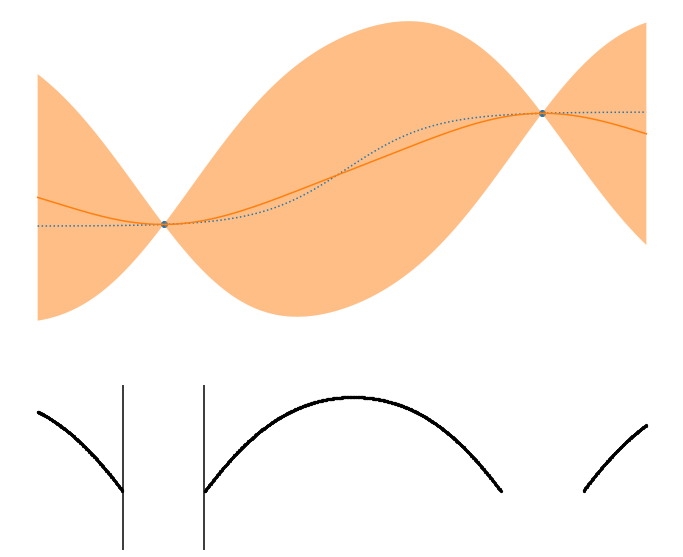

In [10]:
fig, axes = plt.subplots(2, 1, figsize=[12, 10], gridspec_kw={'height_ratios': [2, 1]})

# original GP
plt.subplot(2,1,1)
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.plot(X, mean_prediction_c, label="Mean prediction")
# plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)


# plt.legend()
plt.xlabel("$x$")
plt.ylabel("$C(x)$")
# _ = plt.title("Gaussian process regression on noise-free dataset")
plt.axis('off')

# acquisition function
plt.subplot(2,1,2,)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=5, c="black")
acq_c_argmax = acq_c.argmax()
plt.axis('off')
# plt.scatter()

plt.ylim(0, 1)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
plt.axvline(x = X[ucb_c_idx[0]], color = 'black')
plt.axvline(x = X[ucb_c_idx[1]], color = 'black', label=r'$U_c$ Boundary')

plt.savefig('EG1D_C_simple.png')



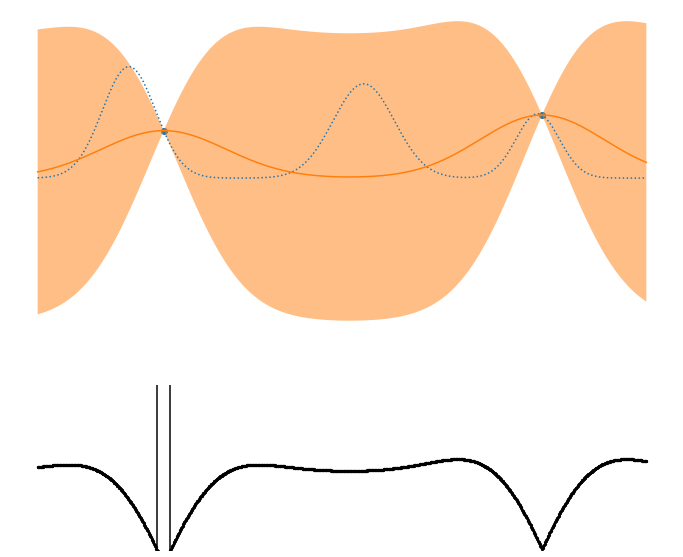

In [11]:
fig, axes = plt.subplots(2, 1, figsize=[12, 10], gridspec_kw={'height_ratios': [2, 1]})
plt.subplot(2,1,1)
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train.squeeze(), label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.axis('off')


plt.subplot(2,1,2)
plt.scatter(X, acq_f, label="Acquisition function", s=5, c='black')
plt.axvline(x = X[ucb_f_idx[0]], color = 'black')
plt.axvline(x = X[ucb_f_idx[1]], color = 'black', label=r"$ROI_f$ Boundary")

plt.ylim(0, 1)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
plt.axis('off')
# plt.legend()
plt.savefig('EG1D_F_simple.png')

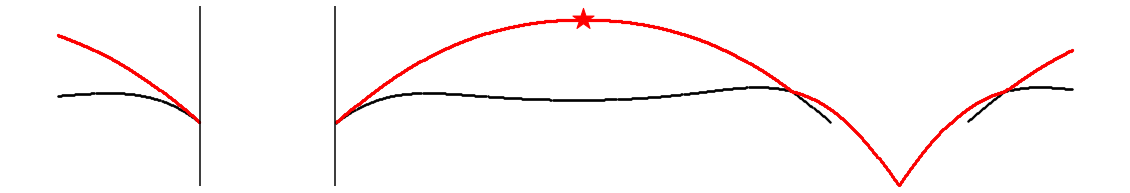

In [12]:
fig, axes = plt.subplots(1, 1, figsize=[20, 3.3])

plt.scatter(X[next_idx], acq_c[next_idx], s=500, c='red', marker='*', label="Next Evaluation")
plt.scatter(X[acq_c_filter_ucb], acq_f[acq_c_filter_ucb], label=r"Acquisition function for Optimizing $f$", s=2, color = 'black')
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label=r"Acquisition Function for Learning $c$", s=2, color = 'black')
plt.scatter(X[acq_c_filter_ucb], np.vstack([acq_c[acq_c_filter_ucb], acq_f[acq_c_filter_ucb]]).max(axis=0), 
            label=r"Acquisition Function for Learning $c$", s=5, c='red')
plt.ylim(0, 1)
# plt.axvline(x = sci_lb, color = 'black', )
# plt.axvline(x = sci_rb, color = 'black',  label=r'$S_c$ Boundary')
plt.axvline(x = X[ucb_c_idx[0]], color = 'black')
plt.axvline(x = X[ucb_c_idx[1]], color = 'black', label=r'$ROI$ Boundary')
plt.axis('off')
plt.savefig('EG1D_ACQ_simple.png')
# plt.xlabel("$x$", fontsize=20)
# plt.ylabel("Acquisition", fontsize=20)
# plt.legend(loc='lower left')
# _ = plt.title(r"Adaptive active learning and optimization", fontsize=20)

## Noisy Version

In [13]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

NameError: name 'rng' is not defined

We create a similar Gaussian process model. In addition to the kernel, this
time, we specify the parameter `alpha` which can be interpreted as the
variance of a Gaussian noise.



In [ ]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

Let's plot the mean prediction and the uncertainty region as before.



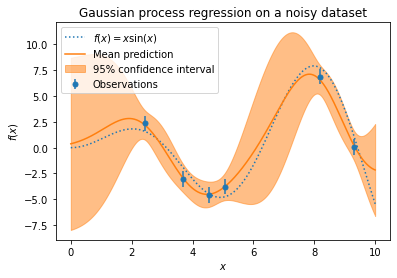

In [ ]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

The noise affects the predictions close to the training samples: the
predictive uncertainty near to the training samples is larger because we
explicitly model a given level target noise independent of the input
variable.

